# <ins>Census Income Predictive Analysis</ins>

The objective of this project is to create a predictive machine learning model based on a UCI census dataset of income from 1996. It will make use of scikit-learn to build a machine learning pipeline that will preprocess the data before applying a random forest classifier that will be further optimized with GridSearchCV to tune hyperparamters for optimal accuracy.

#### Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#### Read dataset as pandas dataframe:

In [2]:
# read file with census data as csv ('adult.data')

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.data', header=None, names = col_names)

## <ins>Feature Engineering</ins>

In [3]:
print(df.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50

In [4]:
print(df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


#### Upon looking at the data file, all comma separated variables of the object type contain a space at the beginning.

In [5]:
# strip all object variables to remove the space

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

#### Separate Features From Target:

In [6]:
# separate features and target variable

X = df.drop(columns=['income'])  # features
y = df['income']                 # target variable

# encode target variable into numerical labels (0 and 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(f'Encoded Classes: {label_encoder.classes_}')

Encoded Classes: ['<=50K' '>50K']


#### Separate Numeric and Categorical Columns:

In [7]:
# separate numerical and categorical features based on unique values

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Columns in DataFrame:", X.columns.tolist())
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Columns in DataFrame: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Numerical Features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## <ins>Train-Test Split, Pipeline, & Fitting</ins> 

In [8]:
# split the data
# test size 0.2 for a 20% testing sample
# random state 42 for repeatability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define preprocessing steps

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# define pipeline to apply preprocessing and train model


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# train the model

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [9]:
# evaluate model
test_score = pipeline.score(X_test, y_test)
print(f'Test Accuracy: {test_score}')

Test Accuracy: 0.8595117457392907


#### Use param_grid & GridSearchCV With Random Forest:

In [10]:
# create grid for hyperparameter tuning
# strict grid to avoid overfitting

# param_grid v1:
 
# param_grid = {
#     'classifier__n_estimators': [50, 100], # number of trees
#     'classifier__max_depth': [10, 20],
#     'classifier__min_samples_split': [10],
#     'classifier__min_samples_leaf': [5]
# }
### Output: 
## Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 5, 
## 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
## Test Score: 0.8599723629663749

### param_grid v2 below:

# param_grid = {
#     'classifier__n_estimators': [50, 100, 200, 300],  # increase range for number of trees
#     'classifier__max_depth': [20, 30, 40],            # explore deeper trees
#     'classifier__min_samples_split': [5, 10, 15],     # test smaller splits
#     'classifier__min_samples_leaf': [3, 5, 10]        # enclude smaller leaves
# }
### v2 took too long to compile

# param_grid v3:

param_grid = {
    'classifier__n_estimators': [50, 100],       # minimum effective range
    'classifier__max_depth': [20],              # single depth (use the best from the previous run)
    'classifier__min_samples_split': [10],      # single split (use the best from the previous run)
    'classifier__min_samples_leaf': [3, 5]      # two options to allow some variance
}


# create GridSearchCV classifier and fit it to training data
# cv is set to 5 to test on 5 folds of the data

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'education-num',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [20],
                         'classifier__min_samples_leaf': [3, 5],
                         'classifier__min_samples_split': [10],
                         'classifier__n_estimators': [50, 100]})

#### Evaluate Best Paramters:

In [11]:
# calculate best parameters

print(f'Best Parameters: {grid_search.best_params_}')

# calculate the score of the model on the testing data

print(f'Test Score: {grid_search.score(X_test, y_test)}')

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Test Score: 0.8615077537233226


Score improved slightly by tuning param_grid.

## <ins>Feature Importance</ins>

Top 10 Important Features:
                              Feature  Importance
3                        capital-gain    0.146472
33  marital-status_Married-civ-spouse    0.117997
2                       education-num    0.113098
53               relationship_Husband    0.085100
0                                 age    0.080237
35       marital-status_Never-married    0.051316
5                      hours-per-week    0.045873
4                        capital-loss    0.032407
42         occupation_Exec-managerial    0.028526
1                              fnlwgt    0.025522


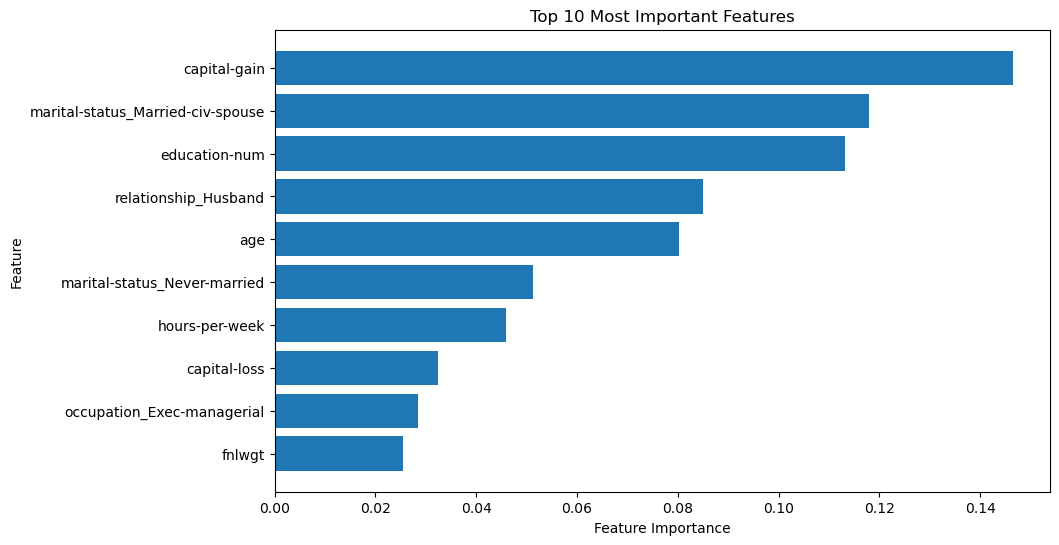

In [12]:
# extract the best model from GridSearchCV

best_model = grid_search.best_estimator_.named_steps['classifier']

# get feature importances

importances = best_model.feature_importances_

# get feature names from the preprocessor
# combine numerical and one-hot-encoded categorical feature names

num_features = numerical_features
cat_features = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_features])

# create a dataframe for visualization

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# display the top 10 features

print("Top 10 Important Features:")
print(importance_df.head(10))

# Visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

## <ins>Visualizing The Model's Performance</ins>

#### Confusion Matrix:

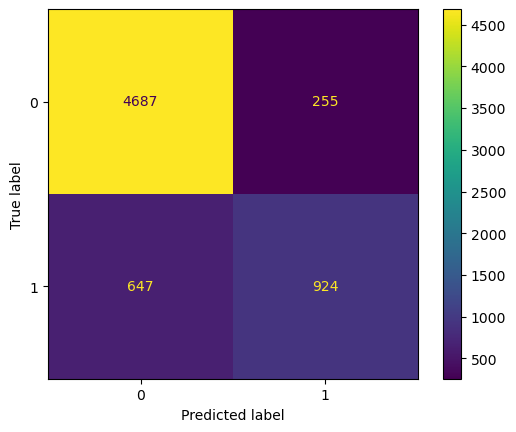

In [13]:
# generate predictions for the test set

y_pred = grid_search.best_estimator_.predict(X_test)

# plot the confusion matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

The model appears to be accurate with the vast majority of the values being in the true positive box (top left), or the true negative box (bottom right).

#### Learning Curve:

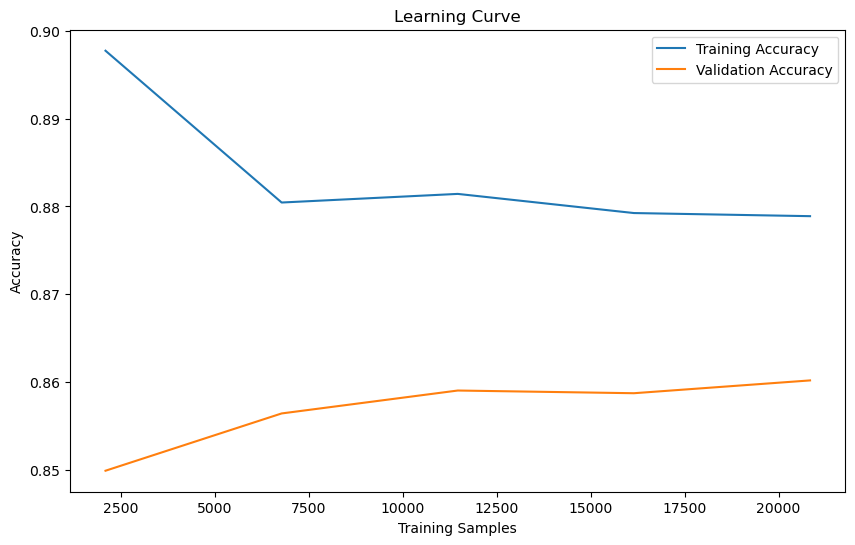

In [14]:
# generate learning curve data

train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

# calculate mean and standard deviation for training and test scores

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# plot learning curve

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

Sample size appears to increase accuracy continuously but the most performance is gained for both the training and validation accuracy at about 12,000 samples.

#### ROC Curve:

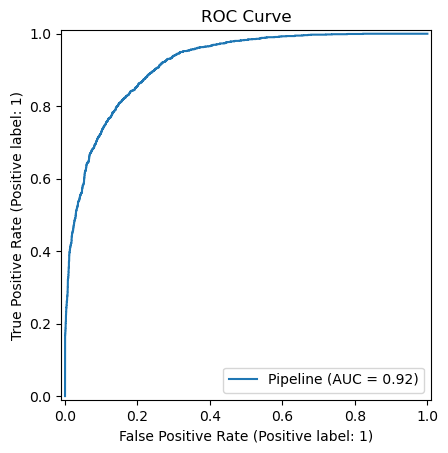

In [15]:
from sklearn.metrics import RocCurveDisplay

# plot ROC Curve
RocCurveDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
plt.title("ROC Curve")
plt.show()


The curve is far from diagonal and the area under the curve is high with the curve being close to the top left corner, indicating a high true positive rate and low false negative rate.

## <ins>Conclusion</ins>

The objective of this project was to develop a predictive machine learning model to classify income levels based on the UCI Census dataset using Python and scikit-learn. Throughout this project, I applied various data science and machine learning techniques, which allowed me to effectively preprocess the data, build a robust classification model, and optimize its performance.